# Estimating LDP for the entropy production in Active Brownian Particle Systems
Consider the active Brownian particle system:
$$d\pmb{r}_i = -\nabla U(\pmb{r}) + v\pmb{b}_i + \sqrt{2D_t} dW_t$$
where $U$ is the purely repulsive WCA potential, $v$ is the magnitude of self-propulsion force, $\pmb{b}$ is unit vector which direction is diffusive, and $W_t$ is a Wiener process.
The dynamical observable of interest is the average entropy production per particle:
$$s = \frac{1}{NT}\sum_{i=1}^N\int_0^T v\pmb{b}_i D_t^{-1}\circ d\pmb{r}_i$$

In [1]:
import numpy as np
import torch
import time
import os
import sys
import torchsde
from torch import nn
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
# defining a DeepRitz block: f_i(s) = ϕ(Wi2 . ϕ(Wi1 . s +bi1) + bi2) + s
class DeepRitz_block(nn.Module):
    def __init__(self, h_size):
        super(DeepRitz_block, self).__init__()
        self.dim_h = h_size

        self.activation_function = nn.Tanh()
        block = [nn.Linear(self.dim_h, self.dim_h),
                 self.activation_function,
                 nn.Linear(self.dim_h, self.dim_h),
                 self.activation_function]
        self._block = nn.Sequential(*block)
    def forward(self, x):
        return self._block(x) + x

# defining the neural network constructed by DeepRitz blocks
class Neural_Network(nn.Module):
    def __init__(self, in_size, h_size = 10, block_size = 1, unit_size = 10., dev="cpu"):
        super(Neural_Network, self).__init__()
        self.num_blocks = block_size
        self.dim_x = in_size
        self.dim_h = h_size
        self.unit_size = unit_size
        self.dev = dev
        self.dim_in = 1 + self.dim_x * 2
        # assemble the neural network with DeepRitz blocks
        self._block = DeepRitz_block(self.dim_h)
        if self.dim_h > self.dim_in:
            model = [nn.ConstantPad1d((0, self.dim_h - self.dim_in), 0)]
        else:
            model = [nn.Linear(self.dim_in, self.dim_h)]
        for _ in range(self.num_blocks):
            model.append(self._block)
        model.append(nn.Linear(self.dim_h, 2*self.dim_x))
        self._model = nn.Sequential(*model)

    def forward(self, dX1, dX2, bias):
        y = torch.cat([dX1,
                       dX2,
                       bias], -1)
        return self._model(y)

In [3]:
# defining the dynamical system of interests: dX_t = F(X_t)dt + \sqrt{2\epsilon}dW_t
# active Brownian particles
class ODE(nn.Module):
    def __init__(self, num_particles, v, unit_size, dev):
        super().__init__()
        self.epsilon = 1.
        self.dim_r = num_particles
        self.unit_size = unit_size
        self.v = v

        self.corrector = 2**(1/3)*torch.eye(num_particles).to(dev)

    def F(self, theta, dX1, dX2):
        dis = dX1**2 + dX2**2 + self.corrector.expand([*theta.shape[:-1], self.dim_r,self.dim_r])
        
        dU = torch.relu(dis**(-13/2) - 1/2 * dis**(-7/2))
        
        F1 = 48.*self.epsilon * (dU * dX1).sum(-1) + self.v * torch.cos(theta)
        F2 = 48.*self.epsilon * (dU * dX2).sum(-1) + self.v * torch.sin(theta)
        
        return torch.cat([F1, F2, torch.zeros(F1.shape).to(dev)], -1)
    
    def forward(self, theta, dX1, dX2):
        return self.F(theta, dX1, dX2)
    
# defining the SDE with trial driven force u(x) and fixed diffusion matrix D
class SDE(nn.Module):
    sde_type = 'stratonovich'
#     sde_type = 'ito'
    noise_type = 'general'

    def __init__(self, Drift, Diffusion, unit_size=10., dev = "cpu"):
        super(SDE, self).__init__()
        self.dev = dev
        self.dim_x = Diffusion.size(1)                      # dimensions of SDE (3 * number of particles)
        self.unit_size = unit_size                          # length of the simulation box
        self.dim_x_ABP = int(2/3*self.dim_x)                # dimensions of NN output (2 * number of particles)
        self.dim_r = self.dim_x//3                          # number of particles

        # (uncontrolled) drift & const diffusion matrix D:
        self._drift_0 = Drift.to(dev)
        self._diffusion = Diffusion.to(dev)
        
    # Minimum Imaging Convention
    def MIC(self, x):
        return (x + self.unit_size/2) % self.unit_size - self.unit_size/2
    
    # Periodic Boundary Condition
    def PBC(self, x):
        x[...,:self.dim_x_ABP] = x[...,:self.dim_x_ABP] % self.unit_size
        x[...,self.dim_x_ABP:] = x[...,self.dim_x_ABP:] % (2 * np.pi)
        return x
    
    # Input of neural network: substract the position of each particle from the 1st one to avoid boundary effects
    def NN_input(self, x):
        return sde.MIC(x - x[...,:1])
    
    # the control force u(x)
    def drift(self, t, x):
        x = self.PBC(x)
        dX1 = x[...,:self.dim_r].unsqueeze(-1).expand(-1,-1,self.dim_r)
        dX2 = x[...,self.dim_r:2*self.dim_r].unsqueeze(-1).expand(-1,-1,self.dim_r)
        dX1 = self.MIC(dX1-dX1.transpose(-1,-2))
        dX2 = self.MIC(dX2-dX2.transpose(-1,-2))
        
        # δu(x)
        F = torch.cat([neural_network(self.NN_input(x[...,:self.dim_r]),
                                      self.NN_input(x[...,self.dim_r:2*self.dim_r]),
                                      biasing_field), 
                       torch.zeros([*dX1.shape[:-2], self.dim_r]).to(dev)], -1)
        
        # uncontrolled drift
        F0 = self._drift_0(x[...,self.dim_x_ABP:], dX1, dX2)
        
        return F + F0

    # the diffusion matrix
    def diffusion(self, t, x):
        return self._diffusion.expand(x.size(0), self.dim_x, self.dim_x)

    # the F(x)
    def drift_0(self, t, x):
        x = self.PBC(x)
        dX1 = x[...,:self.dim_r].unsqueeze(-1).expand(-1,-1,self.dim_r)
        dX2 = x[...,self.dim_r:2*self.dim_r].unsqueeze(-1).expand(-1,-1,self.dim_r)
        dX1 = self.MIC(dX1-dX1.transpose(-1,-2))
        dX2 = self.MIC(dX2-dX2.transpose(-1,-2))
        return self._drift_0(x[...,2*self.dim_r:], dX1, dX2)
    
def replica_exchange(traj, x_init):
    swaps = batch_size1
    with torch.no_grad():
        swap = [np.random.choice(batch_size0, swaps, replace=False), 
                np.random.choice(batch_size1, swaps, replace=False)+batch_size0]
        M_T0 = torch.sum((sde.MIC(traj[1:,swap[0],:2*dim_x]-traj[:-1,swap[0],:2*dim_x])/dt-(F+F0)[:,swap[0]])**2, (0,-1))
        M_T1 = torch.sum((sde.MIC(traj[1:,swap[1],:2*dim_x]-traj[:-1,swap[1],:2*dim_x])/dt-(F+F0)[:,swap[1]])**2, (0,-1))
        M_T = -(M_T0 - M_T1).cpu().detach().numpy() * dt /4
        j = np.argwhere(np.random.rand(swaps) < np.exp(M_T)).T[0]
        x_init[[*swap[0][j],*swap[1][j]]] = x_init[[*swap[1][j],*swap[0][j]]]
        print('%i replica swapped' % j.size)
    return x_init

In [4]:
dim_x, dim_h, num_blocks = 40, 1000, 6
Dt, v = 1, 10
unit_size = np.sqrt(dim_x / 0.1) + 0.0001

dev = "cuda:0" if torch.cuda.is_available() else "cpu"
print(dev)

neural_network = Neural_Network(dim_x, dim_h, num_blocks, unit_size, dev).to(dev)

Dt = 1.
Dr = 3.*Dt
diffusion = torch.tensor( np.sqrt(2 * np.kron(np.diag([Dt, Dt, Dr]), np.eye(dim_x))) ).float().to(dev)

ode = ODE(dim_x, v, unit_size, dev)
sde = SDE(ode, diffusion, unit_size, dev).to(dev)
if sde.sde_type == 'ito':
    sde_method = 'euler'
else:
    sde_method = 'midpoint'
Psi = []
A_T = []
K_T = []

cuda:0


Demonstration of the training with $\lambda=-0.05$. For concurrent training, set _Bias0_ a different value.

In [5]:
dt = 1e-4
T = 1000 * dt

batch_size0, batch_size1 = 50, 50
batch_size = batch_size0 + batch_size1
LR = 1e-2
Bias0 = -0.05
Bias1 = -0.05
biasing_field = torch.cat([Bias0 * torch.ones([batch_size0, 1]).to(dev), 
                           Bias1 * torch.ones([batch_size1, 1]).to(dev)])

x0 = torch.cat([torch.rand([batch_size, dim_x*2]) * unit_size, torch.rand([batch_size, dim_x]) * 2 * np.pi],-1).to(dev)
with torch.no_grad():
    x_init = torchsde.sdeint(sde, x0.to(dev), torch.arange(0, .1+dt, dt).to(dev), dt = dt, 
                         method=sde_method, names={'drift': 'drift', 'diffusion': 'diffusion'})[-1]
optimizer = torch.optim.Adadelta(neural_network.parameters(), lr = LR)

In [ ]:
ts = torch.arange(0, T+dt, dt).to(dev)
normalisation = dim_x * T

step = 0
while step < 20000:
    start_time = time.time()

    optimizer.zero_grad()

    # Generating a batch of trajectories
    with torch.no_grad():
        traj = torchsde.sdeint(sde, x_init.to(dev), ts, dt = dt,
                               method=sde_method, names={'drift': 'drift', 'diffusion': 'diffusion'})
    
    ###################################################################################################
    ## Computing K_T & A_T silmutaneously:
        dX1 = traj[...,:dim_x].unsqueeze(-1).expand(*traj.shape[:-1],dim_x, dim_x)
        dX2 = traj[...,dim_x:2*dim_x].unsqueeze(-1).expand(*traj.shape[:-1],dim_x, dim_x)
        dX1 = sde.MIC(dX1-dX1.transpose(-1,-2))
        dX2 = sde.MIC(dX2-dX2.transpose(-1,-2))
    
    F0 = ode(traj[...,2*dim_x:], dX1, dX2)[:-1,:,:2*dim_x]
    F = neural_network(sde.NN_input(traj[...,:dim_x]),
                       sde.NN_input(traj[...,dim_x:2*dim_x]),
                       biasing_field.expand([*traj.shape[:-1],1]))[:-1]
    dX = (F + F0) * dt
    b = torch.cat([torch.cos(traj[:,:,2*dim_x:]), torch.sin(traj[:,:,2*dim_x:])], 2)
    
    K = torch.sum(F**2, (0,-1))/Dt/2*dt/normalisation
    A = v/Dt * torch.sum((b[1:]+b[:-1])/2 * dX, (0,-1))/normalisation
    ###################################################################################################
    
    ###################################################################################################
    ## Alternative approach: computing K_T & A_T step by step to save memory:
#     K = torch.zeros(batch_size).to(dev)
#     A = torch.zeros(batch_size).to(dev)
#     for i in range(traj.shape[0]):
#         dX1 = torch.einsum('...j, k->...jk', traj[i:i+1,:,:dim_x], sde.vec_one)
#         dX2 = torch.einsum('...j, k->...jk', traj[i:i+1,:,dim_x:2*dim_x], sde.vec_one)
#         dX1 = traj[i:i+1,:,:dim_x].unsqueeze(-1).expand(-1,-1,dim_x)
#         dX2 = traj[i:i+1,:,dim_x:2*dim_x].unsqueeze(-1).expand(-1,-1,dim_x)
#         dX1 = sde.MIC(dX1-dX1.transpose(-1,-2))
#         dX2 = sde.MIC(dX2-dX2.transpose(-1,-2))
    
#         F = neural_network(sde.NN_input(traj[i:i+1,:,:dim_x]),
#                            sde.NN_input(traj[i:i+1,:,dim_x:2*dim_x]),
#                            k[None])
#         F0 = ode(traj[i:i+1,:,2*dim_x:], dX1, dX2)[...,:2*dim_x]
#         b = torch.cat([torch.cos(traj[i:i+1,:,2*dim_x:]), torch.sin(traj[i:i+1,:,2*dim_x:])], 2)
#         dX = (F + F0) * dt

#         K = K + torch.sum(F**2, (0,-1))/Dt/2*dt/normalisation
#         A = A + v/Dt * torch.sum(b * dX, (0,-1))/normalisation
    ###################################################################################################
    
    ## Computing the Lagrangian:
    loss_batch = (K - biasing_field.squeeze() * dim_x * A)
    loss = loss_batch.mean()

    assert not torch.isnan(loss), "Houston we've got a NaN"

    loss.backward()

    resample = False
    for p in neural_network.parameters():
        if p.grad.max() > 1e4:
            resample = True
            print("Houston we need to re-sample", p.grad.max())
            break
    if resample == False:
        Psi.append(-loss_batch.cpu().detach().numpy()/dim_x)
        K_T.append(K.cpu().detach().numpy())
        A_T.append(A.cpu().detach().numpy())
        step += 1
        x_init = traj[-1].detach()
        
        # Replica Exchange
        if Bias0 != Bias1:
            x_init = replica_exchange(traj, x_init)
        
        optimizer.step()
        
        t_simul = time.time()
        print('step %i - time: %.2f sec - SCGF: %.4f * %.4f - %.4f = %.4f' 
              % (step, float(t_simul-start_time), biasing_field[0], 
                 np.mean(A_T[-1][:batch_size0]), np.mean(K_T[-1][:batch_size0]), np.mean(Psi[-1][:batch_size0])))

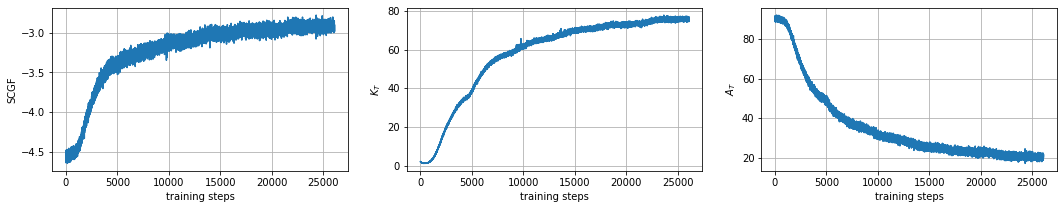

SCGF = 2.9134502 , EP = 20.370098


In [51]:
plt.figure(figsize=(18,3))
plt.subplot(1,3,1)
plt.plot(np.array(Psi)[10:,:batch_size0].mean(1))
plt.grid()
# plt.ylim([0,5])
plt.ylabel('SCGF')
plt.xlabel('training steps')
plt.subplot(1,3,2)
plt.plot(np.array(K_T)[0:,:batch_size0].mean(1))
plt.grid()
plt.ylabel(r'$K_T$')
plt.xlabel('training steps')
plt.subplot(1,3,3)
plt.plot(np.array(A_T)[0:,:batch_size0].mean(1))
plt.grid()
plt.ylabel(r'$A_T$')
plt.xlabel('training steps')
plt.show()

print('SCGF =', -np.array(Psi)[-500:,:batch_size0].mean(),', EP =', np.mean(np.array(A_T)[-500:,:batch_size0]))

In [26]:
def plot_vec(x, t):
    vec = x[...,2*dim_x:]
    dx = sde.MIC(x[t+1,0]-x[t,0])
    markersize = 50000/np.pi/unit_size**2*4
    ax = plt.subplot(aspect=1)
    plt.plot([unit_size, unit_size], [0, 2*unit_size],'--', color = 'y')
    plt.plot([0, 2*unit_size], [unit_size, unit_size],'--', color = 'y')
    
    plt.scatter(x[t,0,:dim_x],x[t,0,dim_x:2*dim_x],s=markersize,alpha=0.5, color='c')    
    plt.scatter(unit_size + x[t,0,:dim_x],x[t,0,dim_x:2*dim_x],s=markersize,alpha=0.5, color='c')  
    plt.scatter(x[t,0,:dim_x],unit_size + x[t,0,dim_x:2*dim_x],s=markersize,alpha=0.5, color='c')   
    plt.scatter(unit_size + x[t,0,:dim_x],unit_size + x[t,0,dim_x:2*dim_x],s=markersize,alpha=0.5, color='c')
    
    plt.xlim([0, unit_size + unit_size])
    plt.ylim([0, unit_size + unit_size])
    plt.grid()
    plt.show()

In [46]:
with torch.no_grad():
    traj = torchsde.sdeint(sde, x0.to(dev), torch.arange(0, .3+dt, dt).to(dev), dt = dt, 
                           method=sde_method, names={'drift': 'drift', 'diffusion': 'diffusion'})
x= traj.cpu().detach().numpy()

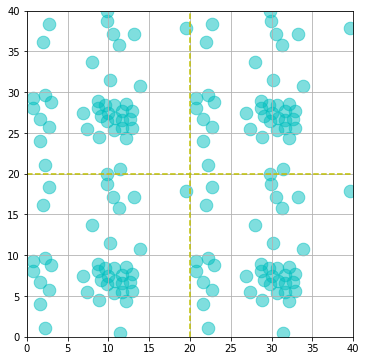

In [49]:
fig = plt.figure(figsize=(6,6))
plot_vec(x, -1)
plt.show()